# Anomaly Detection on Washer Data Set Using U-Net.

# U-Netを用いたWasherデータセットの異常検知。

# Import Necessary Packages.

# 必要なパッケージをインポートします。

In [1]:
import os
import PIL
from PIL import ImageOps
import numpy as np
from IPython.display import Image , display
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda
from tensorflow.keras.preprocessing.image import load_img

# Define Data Directory.

# データディレクトリの定義。

In [2]:
washer_ok_img = os.listdir("washer/washer_ok")
washer_ng_img = os.listdir("washer/washer_ng/kizu")
washer_test_img = os.listdir("washer/washer_ng/sabi")

# Set Up Training Data Path.

# トレーニングデータのパスを設定します。

In [3]:
train_path = []
for  ok_img in washer_ok_img[:30] :
    train_path.append('washer/washer_ok/'+ok_img)
    #valid_path.append('washer/washer_ng/kizu/'+ng_img)

print(len(train_path))

30


# Set Up Validation Data Path.

# バリデーションデータのパスを設定します。

In [4]:
valid_path = []
for ng_img in washer_ng_img[:10]:
    valid_path.append('washer/washer_ng/kizu/'+ng_img)
    
print(len(valid_path))

10


# Set Up Test Data Path.

# テストデータのパスの設定します。

In [5]:
test_path = []

for test_img in washer_test_img:
    test_path.append('washer/washer_ng/sabi/'+test_img)

print(len(test_path))

4


# Define: Image Size, Batch Size, Number of Classes.

# 定義します: 画像サイズ、バッチサイズ、クラスの数。

In [7]:
img_size = (256, 256)
batch_size = 1
num_classes = 2

# Prepare Sequence Class to Load and Vectorize Batches of Data.


# データのバッチをロードしてベクター化するためのシーケンスクラスを用意すします。

In [6]:
class Washer(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        #pass
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Return input correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]

        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x, y

# Implement U-Net Model.

# U-Netモデルの実装。

In [8]:
def simple_unet_model(img_size, num_classes):
#Build the model
    inputs = Input(shape=img_size + (3, ))
    s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    

    #Contraction path
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    drop1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    drop2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop2)
    pool2 = MaxPooling2D((2, 2))(conv2)
     
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    drop3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop3)
    pool3 = MaxPooling2D((2, 2))(conv3)
     
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    drop4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
     
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    drop5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop5)
    
    #Expansive path 
    ups6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    ups6 = concatenate([ups6, conv4])
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(ups6)
    drop6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop6)
     
    ups7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    ups7 = concatenate([ups7, conv3])
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(ups7)
    drop7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop7)
     
    ups8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    ups8 = concatenate([ups8, conv2])
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(ups8)
    drop8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop8)
     
    ups9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    ups9 = concatenate([ups9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(ups9)
    drop9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop9)
     
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [9]:
model = simple_unet_model(img_size,num_classes)

# U-Net Model Architecture.

# U-Netモデルのアーキテクチャ。

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

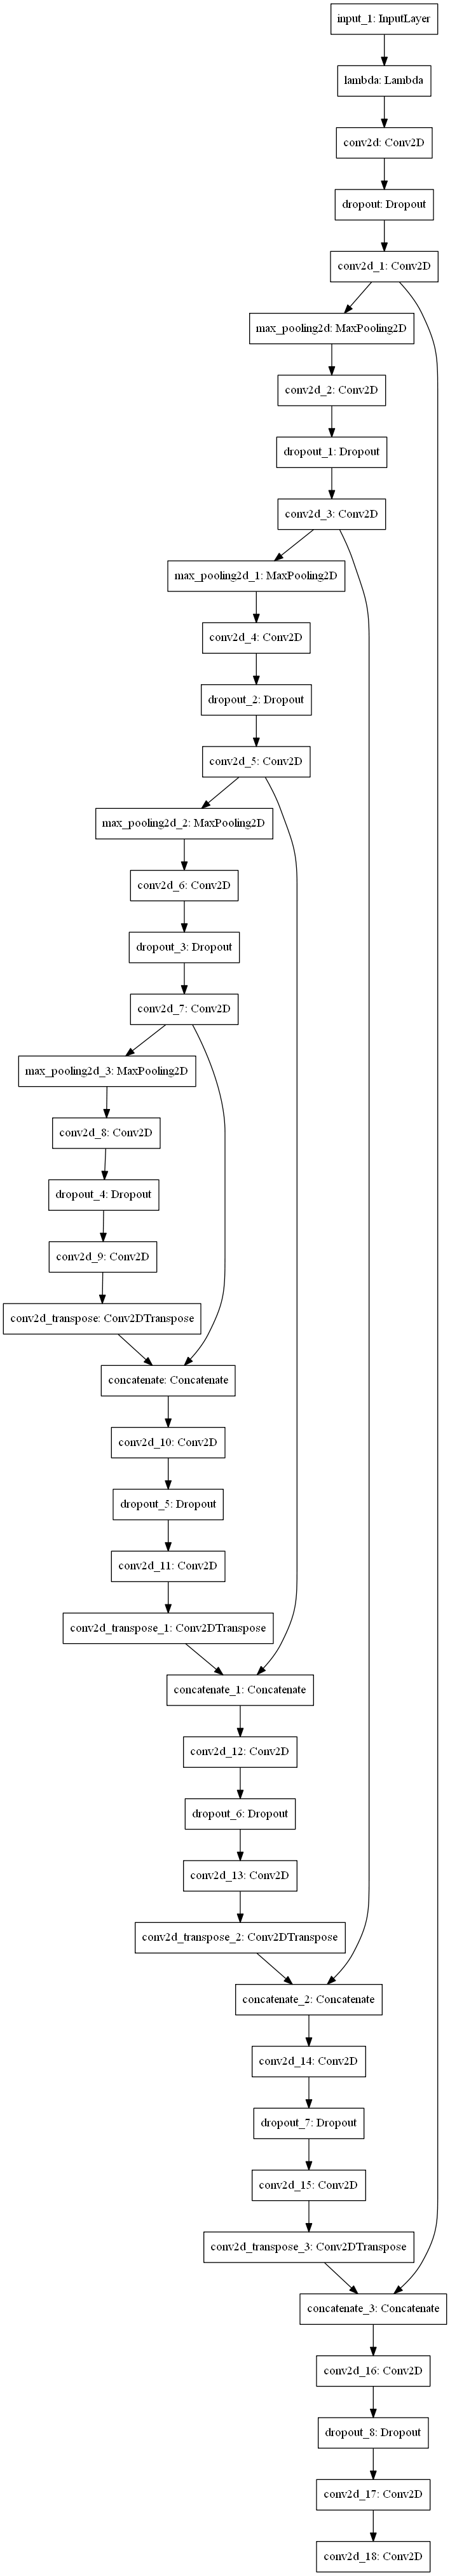

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='U-Net.png')

# Instantiate Data Sequences .

# データシーケンスのインスタンス化 .

In [41]:
train_gen = Washer(batch_size, img_size, train_path)
val_gen = Washer(batch_size, img_size, valid_path)
test_gen = Washer(batch_size, img_size, test_path)

# Train U-Net Model.

# U-Netモデルの学習。

In [42]:
# Configure the model for training.

model.compile(optimizer="adam", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("washer_segmentation_U-Net.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
30/30 [==============================] - 12s 392ms/step - loss: 145.3586 - val_loss: 149.3653
Epoch 2/30
30/30 [==============================] - 12s 384ms/step - loss: 144.3390 - val_loss: 149.3616
Epoch 3/30
30/30 [==============================] - 12s 413ms/step - loss: 144.3133 - val_loss: 149.3598
Epoch 4/30
30/30 [==============================] - 12s 398ms/step - loss: 144.2960 - val_loss: 149.3570
Epoch 5/30
30/30 [==============================] - 12s 387ms/step - loss: 144.2892 - val_loss: 149.3569
Epoch 6/30
30/30 [==============================] - 12s 388ms/step - loss: 144.2892 - val_loss: 149.3569
Epoch 7/30
30/30 [==============================] - 12s 386ms/step - loss: 144.2892 - val_loss: 149.3569
Epoch 8/30
30/30 [==============================] - 12s 398ms/step - loss: 144.2892 - val_loss: 149.3569
Epoch 9/30
30/30 [==============================] - 12s 395ms/step - loss: 144.2892 - val_loss: 149.3569
Epoch 10/30
30/30 [==============================] - 12

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='U-Net.png')

# Loss and Validation Loss Curve.

# 損失とバリデーションの損失曲線.

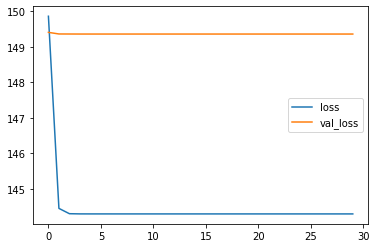

In [29]:
import pandas as pd
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

# Predictions for Images in Test Data Set.

# テストデータセットに含まれる画像の予測値です。


In [30]:
# Generate predictions for all images in the test set
test_gen = Washer(1, img_size, test_path)
test_preds = model.predict(test_gen)

# Inference Test Data with Heat Map.

# ヒートマップによる推論テストデータ。

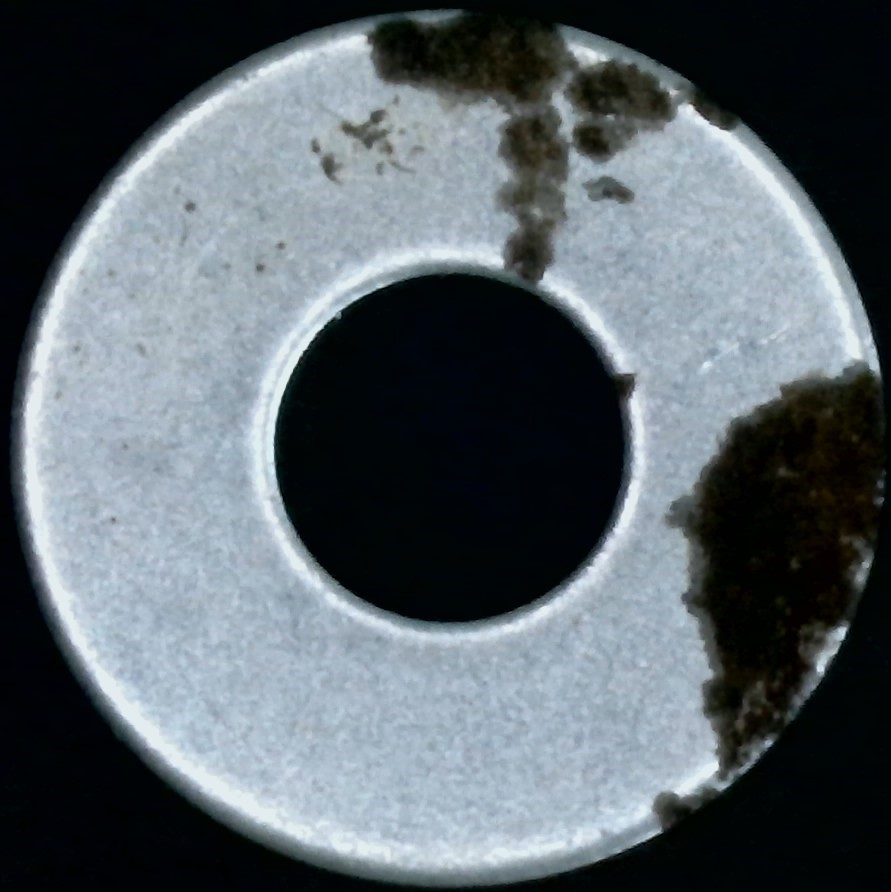

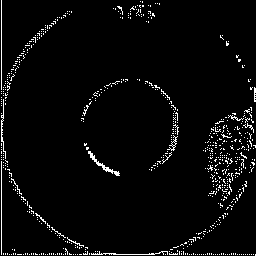

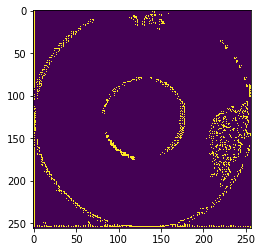

In [31]:
import matplotlib.pyplot as plt
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    plt.imshow(mask)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 3

# Display input image
display(Image(filename=test_path[i], width=224, height=224))


# Display mask predicted by our model
display_mask(i) 